#                       DS 340W Mid-Term Project
## Aarnav Putta and Daniel Gao







*   Data Handling and Numerical Operations: pandas and numpy enable data manipulation and calculations.

*   Machine Learning Models: sklearn provides logistic regression, Lasso, and Ridge models, with cross-validation capabilities.

*   Data Splitting and Cross-Validation: Tools like train_test_split, StratifiedKFold, and GridSearchCV facilitate data partitioning and hyperparameter tuning.

*   Model Evaluation: f1_score from sklearn.metrics allows evaluation of model performance.

*   Feature Selection and Scaling: SelectFromModel and StandardScaler assist in feature selection and standardizing data for improved model accuracy.

*  Data Visualization: seaborn and matplotlib help visualize feature relationships and model insights through charts and heatmaps.











In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt



In this code, we preprocess soil data to create indices that help predict drought risk. We calculate the Soil Quality Index (SQI) by averaging multiple soil quality features, providing a summary measure of soil health. We then compute Slope Variance and Aspect Variance to capture variability in land slope and direction, which affect water retention and exposure. Land Ratio compares forest/grassland to cultivated land, indicating types of land cover with implications for drought. Lastly, we derive the Enhanced Drought Severity Index (EDSI), a normalized measure combining SQI, slope, and land type ratios to assess drought susceptibility effectively.

In [10]:
# Load the dataset
soil_data = pd.read_csv('soil_data.csv')

# 1. Calculate Soil Quality Index (SQI)
soil_data['SQI'] = soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].mean(axis=1)

# 2. Calculate Slope and Aspect Variance
slope_features = ['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']
aspect_features = ['aspectN', 'aspectE', 'aspectS', 'aspectW']
soil_data['Slope_Variance'] = soil_data[slope_features].var(axis=1)
soil_data['Aspect_Variance'] = soil_data[aspect_features].var(axis=1)

# 3. Calculate Land Type Ratios
soil_data['Land_Ratio'] = (soil_data['FOR_LAND'] + soil_data['GRS_LAND']) / (soil_data['CULTRF_LAND'] + 1)

# 4. Calculate Enhanced Drought Severity Index (EDSI)
soil_data['EDSI'] = (soil_data['SQI'] / soil_data['SQI'].max()) - (soil_data['Slope_Variance'] / soil_data['Slope_Variance'].max()) + (soil_data['Land_Ratio'] / soil_data['Land_Ratio'].max())





*   Define Binary Target: Set a threshold for the Enhanced Drought

*   Severity Index (EDSI) at the 70th percentile. Label data points above the threshold as "High Drought Risk" (1) and others as "Low Drought Risk" (0).

*   Prepare Features and Target: Select relevant features (SQI, Slope Variance, Land Ratio, EDSI, elevation) as X, and Drought_Risk as the target variable y.

*   Split Data: Divide data into train, validation, and test sets in a 60-20-20 ratio to ensure robust model evaluation.

*   Standardize Features: Apply standard scaling to normalize X values in training, validation, and test sets, improving model performance.

*   Feature Selection Decision: Based on correlations, select Lasso for sparsity or Ridge for multicollinearity.

*   :Apply Feature Selection: Use LassoCV or RidgeCV to select the most important features based on cross-validation. Transform training, validation, and test sets accordingly to reduce data dimensionality and enhance model efficiency.















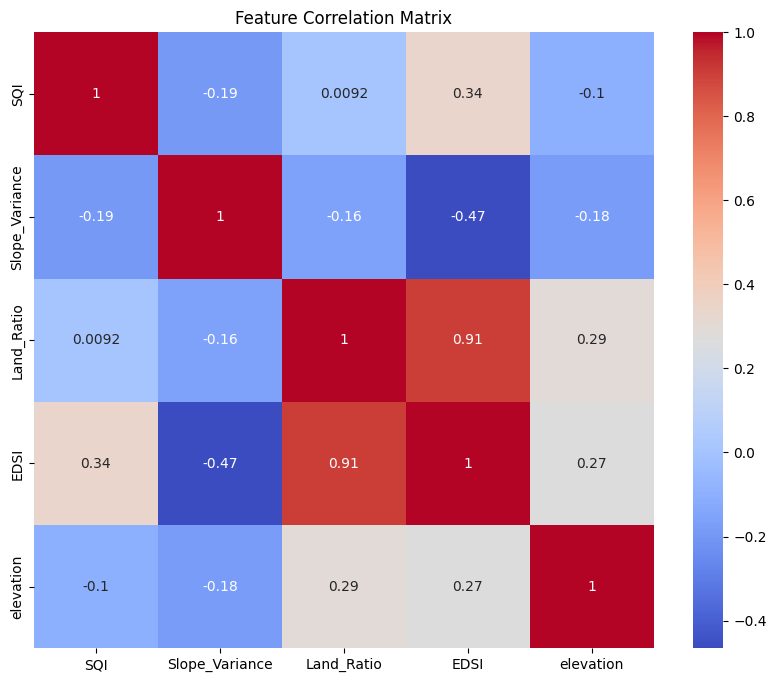

Applying Ridge due to high feature correlation.


In [11]:
# Define a binary target based on EDSI threshold
threshold = soil_data['EDSI'].quantile(0.7)
soil_data['Drought_Risk'] = np.where(soil_data['EDSI'] >= threshold, 1, 0)

# Prepare feature set (X) and target variable (y)
X = soil_data[['SQI', 'Slope_Variance', 'Land_Ratio', 'EDSI', 'elevation']]
y = soil_data['Drought_Risk']

# Split data into train, validation, and test sets (60-20-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 5: Analyze feature relations (correlation matrix)
correlations = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Step 6: Select Feature Selection Model - Lasso if sparsity, Ridge if multicollinearity
# We apply Lasso if there is high sparsity, or Ridge if features are highly correlated
if (correlations.abs() > 0.7).sum().sum() > len(X.columns):  # condition to check multicollinearity
    print("Applying Ridge due to high feature correlation.")
    selector = SelectFromModel(RidgeCV(alphas=np.logspace(-6, 6, 13))).fit(X_train_scaled, y_train)
else:
    print("Applying Lasso due to low feature correlation and potential sparsity.")
    selector = SelectFromModel(LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)).fit(X_train_scaled, y_train)

# Transform the features based on selection
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)





*   Define Parameter Grid: Set up a grid of parameters for ElasticNet Logistic Regression, focusing on regularization strength (C), l1_ratio, and saga solver for ElasticNet penalty.

*   Initialize Grid Search with Cross-Validation: Create an instance of LogisticRegression with ElasticNet penalty and use GridSearchCV for hyperparameter tuning, evaluating F1 scores across 5-fold cross-validation.


*   Fit Grid Search Model: Fit the model on the training data (X_train_selected, y_train) to find the optimal combination of parameters based on F1 scores.

*   Display Hyperparameter Tuning Results: Loop through each parameter set tried in GridSearchCV, displaying the mean F1 scores for training and testing across folds, allowing for detailed model comparison.


*   Best Parameters and Score: Output the best parameter combination and the highest cross-validated F1 score achieved during grid search.

*   Evaluate on Validation and Test Sets: Use the best estimator to make predictions on the validation and test sets, then calculate and print F1 scores for both, assessing model performance on unseen data.







In [12]:
# Define parameter grid for ElasticNet Logistic Regression with regularization
param_grid_elasticnet = {
    'C': [0.001, 0.01, 0.05, 0.1],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.8, 0.9]
}

# ElasticNet Logistic Regression with cross-validation and GridSearchCV
elasticnet_model = LogisticRegression(random_state=42, max_iter=300)
grid_search_elasticnet = GridSearchCV(
    estimator=elasticnet_model,
    param_grid=param_grid_elasticnet,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)
grid_search_elasticnet.fit(X_train_selected, y_train)

# Display parameters tried and their F1 scores for each fold
print("ElasticNet Logistic Regression - Hyperparameter Tuning Results:")
for i, params in enumerate(grid_search_elasticnet.cv_results_['params']):
    mean_train_score = grid_search_elasticnet.cv_results_['mean_train_score'][i]
    mean_test_score = grid_search_elasticnet.cv_results_['mean_test_score'][i]
    print(f"Parameters: {params} | Mean Train F1 Score: {mean_train_score:.4f} | Mean Test F1 Score: {mean_test_score:.4f}")

# Best parameters and score
print("\nBest Parameters from Grid Search:", grid_search_elasticnet.best_params_)
print(" - Best Cross-Validation F1 Score:", grid_search_elasticnet.best_score_)

# Evaluate on validation and test sets
y_val_pred_elasticnet = grid_search_elasticnet.best_estimator_.predict(X_val_selected)
y_test_pred_elasticnet = grid_search_elasticnet.best_estimator_.predict(X_test_selected)

val_f1_elasticnet = f1_score(y_val, y_val_pred_elasticnet)
test_f1_elasticnet = f1_score(y_test, y_test_pred_elasticnet)

print("\nValidation F1 Score for ElasticNet Logistic Regression:", val_f1_elasticnet)
print("Test F1 Score for ElasticNet Logistic Regression:", test_f1_elasticnet)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
ElasticNet Logistic Regression - Hyperparameter Tuning Results:
Parameters: {'C': 0.001, 'l1_ratio': 0.8, 'penalty': 'elasticnet', 'solver': 'saga'} | Mean Train F1 Score: 0.0000 | Mean Test F1 Score: 0.0000
Parameters: {'C': 0.001, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'} | Mean Train F1 Score: 0.0000 | Mean Test F1 Score: 0.0000
Parameters: {'C': 0.01, 'l1_ratio': 0.8, 'penalty': 'elasticnet', 'solver': 'saga'} | Mean Train F1 Score: 0.9170 | Mean Test F1 Score: 0.9177
Parameters: {'C': 0.01, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'} | Mean Train F1 Score: 0.9182 | Mean Test F1 Score: 0.9187
Parameters: {'C': 0.05, 'l1_ratio': 0.8, 'penalty': 'elasticnet', 'solver': 'saga'} | Mean Train F1 Score: 0.9607 | Mean Test F1 Score: 0.9620
Parameters: {'C': 0.05, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'} | Mean Train F1 Score: 0.9644 | Mean Test F1 Score: 0.9620
Parameters: {'C'


*   Effective Use of EDSI: EDSI (Enhanced Drought Severity Index) proved effective in predicting drought risk, providing a useful metric for drought analysis.

*   High Model Performance: Achieved strong F1 scores on validation and test sets, indicating robust predictions with minimal overfitting.

*   Use of Lasso and Ridge Regularization: ElasticNet (combining Lasso and Ridge) helped manage multicollinearity and sparsity in features, leading to a streamlined and interpretable model.

*   Cost Efficiency: By focusing on fewer important features, Lasso and Ridge regularization can reduce data collection costs.

*   Hyperparameter Tuning Value: Grid search optimization underscored the importance of fine-tuning for balanced performance.

*   Recommendations for Research: Incorporating EDSI, tuned regularization techniques, and diverse datasets could enhance the accuracy and generalizability of future drought prediction models.











